<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/twyncoder/dl-handson/blob/master/L02b_TrainAdvDNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# Redes de Aprendizaje Profundo básicas con Keras y Tensorflow.
## *Deep Neural Networks (DNN) para clasificación multi-clase*

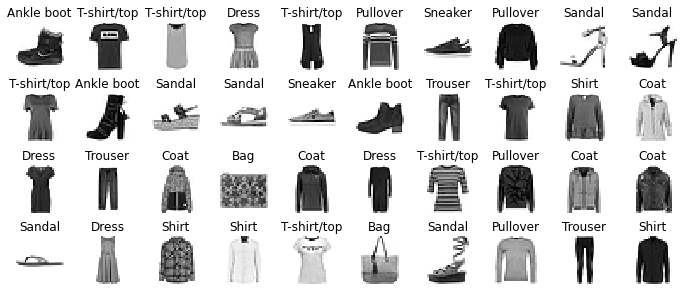

## 0. Preparación del entorno y comprobación de requisitos

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"
from tensorflow import keras

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import pandas as pd

### Información de versiones

In [ ]:
tf.__version__

### Comprobar si disponemos de una GPU

In [ ]:
tf.config.list_physical_devices('GPU')

## 1. Dataset

In [ ]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [ ]:
X_train, X_valid = X_train_full[:55000], X_train_full[55000:]
y_train, y_valid = y_train_full[:55000], y_train_full[55000:]
X_train = X_train / 255.0
X_test = X_test / 255.0
X_valid = X_valid / 255.0

## 2. Entrenamiento

### Modelo 'base' de red neuronal

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
model.summary()

**¡AHORA TÚ!**
- Entrena la red anterior usando _Stochastic Gradient Descent_ durante 35 `epochs` y con un  `learning_rate` de 1e-2 .
- Muestra en una gráfica la evolución del entrenamiento. ¿Se produce sobreentrenamiento?

### Variación dinámica del learning rate
- Una forma de prevenir el sobreentrenamiento es ir disminuyendo de manera dinámica el _learning rate_.
- De hecho, algunos optimizadores lo hacen internamente de manera automática.
- Observa cómo el siguiente modelo de red sobreentrena para `learning_rate` 1e-2 y `epochs` 35.
- Podemos elegir distintas estrategias para ir disminuyendo el _learning rate_.
- Una de las más utilizadas es _Reduce on plateau_, que consiste en añadir un _callback_ para que se reduzca el `learning_rate` cuando el _loss_ se queda en una meseta. Busca información e indica qué controlan los argumentos `monitor`, `factor` y `patience`.

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=1e-2)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.4, patience=2)

- Observa que también es posible escribir _callbacks_ para informar del learning rate al final de cada _epoch_

In [ ]:
class PrintLrCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        # - CUIDADO: Imprimir lr para ver variación no funciona cuando no se usa un callback de keras que actualiza lr internarmente. El lr impreso es constante.
        print("Learning rate: {:.6f}: ".format(keras.backend.eval(self.model.optimizer.learning_rate)))
        
lr_cb = PrintLrCallback()

**¡AHORA TÚ!**
- Añade los _callbacks_ `lr_scheduler` y `lr_cb` durante el entrenamiento.
- Para ejecutar varios _callback_ puedes hacer una lista en la llamada a la función `fit`.

## Técnicas de regularización

### Regularización L1 y L2 

- Podemos incluir regularización L2 con factor 0.01 en las capas Dense de la siguiente manera:

<code> layer = keras.layers.Dense(100, activation="relu",                                  
                      kernel_regularizer=keras.regularizers.l2(0.01)) </code> 
 - `l1(0.1)` para L1 con factor 0.1
 - `l1_l2(0.1, 0.01)` para L1 y L2 con factores 0.1 y 0.01 respectivamente

**¡AHORA TÚ!**
- Modifica la red neuronal base de este _notebook_ para regularizar las capas ocultas con L2 y observa si disminuye el sobreentrenamiento.
- Utiliza un `learning_rate` _agresivo_ de 1e-2. No utilices ninguna técnica de planificación para disminuirlo durante el entrenamiento.
- ¿Qué tal ha ido el entrenamiento esta vez? ¿Qué valores se han obtenido de `val_accuracy` y `accuracy`?

### Early Stopping

- Parar el entrenamiento es una forma de prevenir que la red sobreentrene. Se puede dejar a la red que siga entrenando durante un tiempo, pero utilizar después en la etapa de inferencia los parámetros que proporcionaron mejor loss de validación (distintos de los de la última _epoch_).

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_dnn_model.h5", save_best_only=True)

## 3. Test

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

### Matriz de confusión

In [ ]:
from sklearn.metrics import confusion_matrix
y_true = y_test
y_pred = np.argmax(model.predict(X_test),axis=-1)
conf = confusion_matrix(y_true, y_pred)
print(conf)

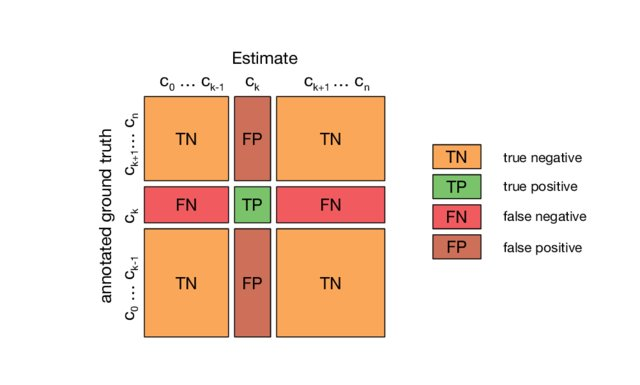

### Métricas de rendimiento

In [ ]:
TP = np.diag(conf)
FP = conf.sum(axis=0) - TP 
FN = conf.sum(axis=1) - TP
TN = conf.sum() - (FP + FN + TP)

**¡AHORA TÚ!**
- Haciendo uso de la imagen de matriz de confusión para problemas multiclase, verifica que los cálculos sean correctos. Puedes imprimir los vectores `TP`, `FP`, `FN` y `TN` para hacer una comprobación rápida.

**¡AHORA TÚ!**
- Calcula e imprime las siguientes métricas para cada clase con dos decimales de precisión:
    - Precision:                     
    $PPV = TP/(TP+FP)$
    - Sensitivity (Recall):  
    $TPR = TP/(TP+FN)$
    - Specificity:           
    $TNR = TN/(TN+FP)$
    - Accuracy:             
    $ACC = (TP+TN)/(TP+FP+FN+TN)$
    - F1-score:             
    $FONE = 2*TP/(2*TP + FP + FN)$

In [ ]:
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)